##### <p> Samuel Wolfe <br> August 8, 2023 <br> MSBA 206 <br> DMBA Chapter 13.1</p>

In [193]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import requests
import io
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

In [194]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import scikitplot as skplt
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary, regressionSummary,liftChart

In [195]:
def readFile(url):
    download = requests.get(url).content
    # Reading the downloaded content and turning it into a pandas dataframe
    df = pd.read_csv(io.StringIO(download.decode('utf-8')))
    return df
def statslist(df):
    dfStats = pd.DataFrame({'Mean' : df.mean(numeric_only=True),
            'SD' : df.std(numeric_only=True),
            'Min' : df.min(),
            'Max' : df.max(),
            'Median' : df.median(numeric_only=True),
            })
    return dfStats
def categorize(df):
    for x in df:
        df[x] = df[x].astype('category')
    return df
def catStringToINT(df,col):
    names = []
    num = []
    for x in df[col].unique():
        names.append((df[col] == x))
    for x in range(len(names)):
        num.append(x+1)
    df[col] = np.select(names, num)
    return df

In [196]:
dfeBay = readFile("https://raw.githubusercontent.com/wolfesamk/MSBA-206/main/dmba/eBayAuctions.csv")

In [197]:
dfeBay

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
...,...,...,...,...,...,...,...,...
1967,Automotive,US,2992,5,Sun,359.95,359.95,0
1968,Automotive,US,21,5,Sat,610.00,300.00,1
1969,Automotive,US,1400,5,Mon,549.00,549.00,0
1970,Automotive,US,57,7,Fri,820.00,650.00,1


In [198]:
outcome = 'Competitive'

In [199]:
dfeBay['Category'] = dfeBay['Category'].replace('/','_', regex=True)
dfeBay['Category'] = dfeBay['Category'].replace(' ','', regex=True)
dfeBay = dfeBay.rename(columns={'Competitive?': outcome})

In [200]:
dfeBay['Duration'] = dfeBay['Duration'].astype('category')
dfeBay['endDay'] = dfeBay['endDay'].astype('category')
dfeBay['currency'] = dfeBay['currency'].astype('category')
dfeBay['Category'] = dfeBay['Category'].astype('category')

In [201]:
dfeBay.head(5)

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive
0,Music_Movie_Game,US,3249,5,Mon,0.01,0.01,0
1,Music_Movie_Game,US,3249,5,Mon,0.01,0.01,0
2,Music_Movie_Game,US,3249,5,Mon,0.01,0.01,0
3,Music_Movie_Game,US,3249,5,Mon,0.01,0.01,0
4,Music_Movie_Game,US,3249,5,Mon,0.01,0.01,0


In [202]:
dfeBay = pd.get_dummies(dfeBay)

In [203]:
truths = [(dfeBay['Competitive'] == 1),
          (dfeBay['Competitive'] == 0)]
meanings = ['Yes', 'No']
dfeBay[outcome] = np.select(truths,meanings)
dfeBay[outcome].value_counts()

Competitive
Yes    1066
No      906
Name: count, dtype: int64

## 13.2.a Regular Tree

In [204]:
drops = ['ClosePrice']

In [205]:
X_eBay = dfeBay.drop(columns=outcome).drop(columns=drops)
Y_eBay = dfeBay[outcome]
X_train, X_valid, y_train, y_valid = train_test_split(X_eBay, Y_eBay, test_size=0.4, random_state=1)

In [206]:
classTree = DecisionTreeClassifier(criterion="gini", random_state=1)
classTree.fit(X_train, y_train)
classificationSummary(y_valid, classTree.predict(X_valid))

Confusion Matrix (Accuracy 0.7047)

       Prediction
Actual   0   1
     0 248 105
     1 128 308


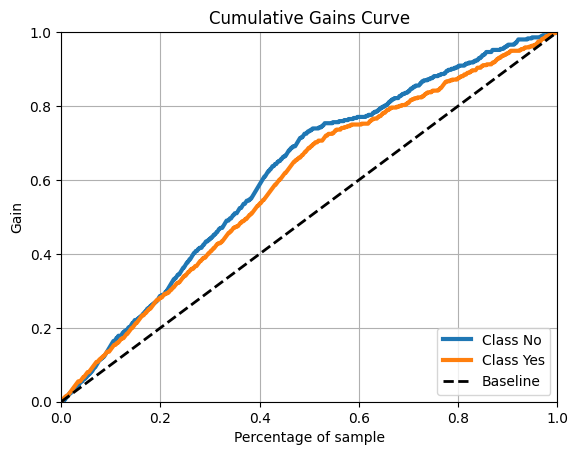

In [207]:
predicted_probas = classTree.predict_proba(X_valid)
skplt.metrics.plot_cumulative_gain(y_valid, predicted_probas)
plt.show()

In [208]:
df_predicted_probas = pd.DataFrame(predicted_probas)
df_predicted_probas['Predicted'] = df_predicted_probas[1]
df_predicted_probas = df_predicted_probas.drop(columns=[0,1])

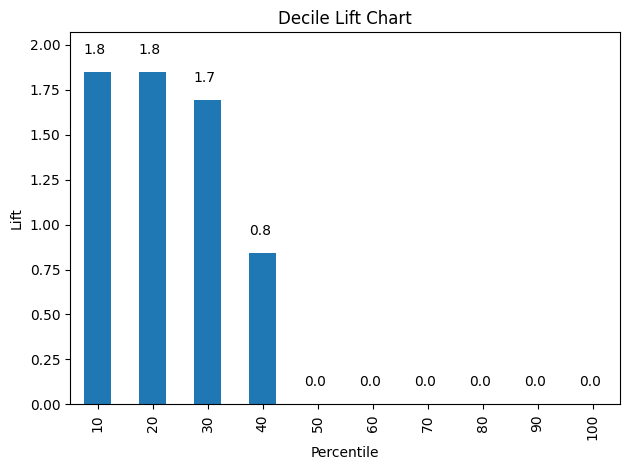

In [209]:
resultPredTrain = pd.DataFrame({'Predicted': df_predicted_probas['Predicted'], 'Actual': y_valid})
liftChart(resultPredTrain.sort_values(by=['Predicted'], ascending=False).Predicted, labelBars=True, title='Decile Lift Chart')
plt.tight_layout()
plt.show()

## 13.2.a The accuracy is  70.47%. The lift on the first decile is 1.8

## 13.2.b AdaBoostClassifier Tree

In [210]:
drops = ['ClosePrice']

In [211]:
X_eBay = dfeBay.drop(columns=outcome).drop(columns=drops)
Y_eBay = dfeBay[outcome]
X_train, X_valid, y_train, y_valid = train_test_split(X_eBay, Y_eBay, test_size=0.4, random_state=1)

In [212]:
classTree = AdaBoostClassifier((DecisionTreeClassifier(criterion="gini", random_state=1)),n_estimators=100, random_state=1)
classTree.fit(X_train, y_train)
classificationSummary(y_valid, classTree.predict(X_valid))

Confusion Matrix (Accuracy 0.6907)

       Prediction
Actual   0   1
     0 245 108
     1 136 300


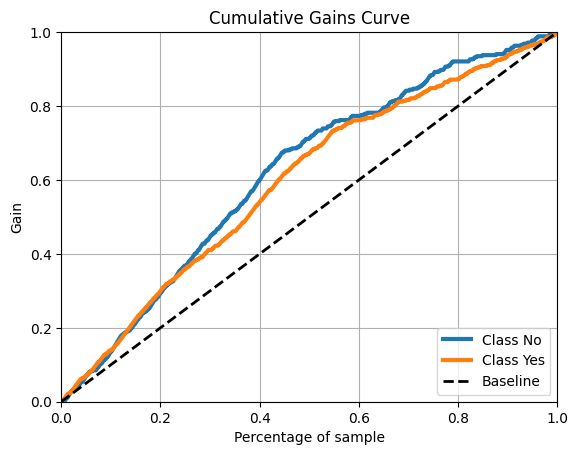

In [213]:
predicted_probas = classTree.predict_proba(X_valid)
skplt.metrics.plot_cumulative_gain(y_valid, predicted_probas)
plt.show()

In [214]:
df_predicted_probas = pd.DataFrame(predicted_probas)
df_predicted_probas['Predicted'] = df_predicted_probas[1]
df_predicted_probas = df_predicted_probas.drop(columns=[0,1])

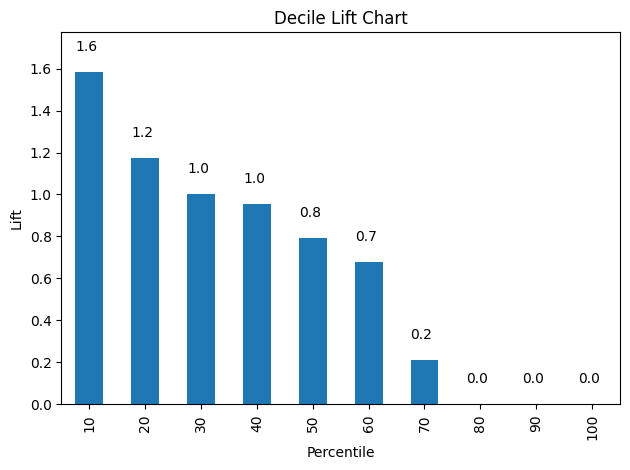

In [215]:
resultPredTrain = pd.DataFrame({'Predicted': df_predicted_probas['Predicted'], 'Actual': y_valid})
liftChart(resultPredTrain.sort_values(by=['Predicted'], ascending=False).Predicted, labelBars=True, title='Decile Lift Chart')
plt.tight_layout()
plt.show()

## 13.2.b The accuracy is  69.07%. The lift on the first decile is 1.6

## 13.2.c BaggingClassifier Tree

In [216]:
drops = ['ClosePrice']

In [217]:
X_eBay = dfeBay.drop(columns=outcome).drop(columns=drops)
Y_eBay = dfeBay[outcome]
X_train, X_valid, y_train, y_valid = train_test_split(X_eBay, Y_eBay, test_size=0.4, random_state=1)

In [218]:
classTree = BaggingClassifier((DecisionTreeClassifier(criterion="gini", random_state=1)),n_estimators=100, random_state=1)
classTree.fit(X_train, y_train)
classificationSummary(y_valid, classTree.predict(X_valid))

Confusion Matrix (Accuracy 0.7212)

       Prediction
Actual   0   1
     0 252 101
     1 119 317


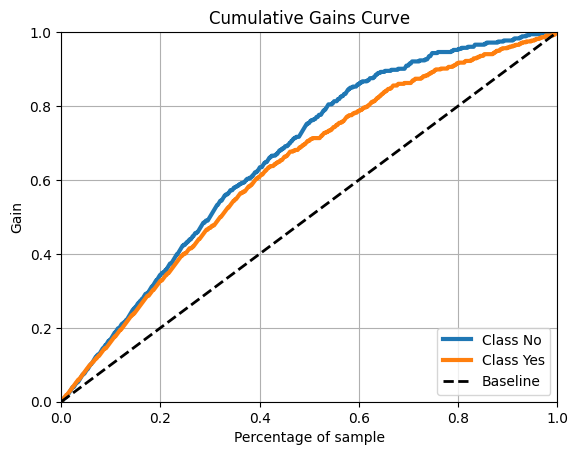

In [219]:
predicted_probas = classTree.predict_proba(X_valid)
skplt.metrics.plot_cumulative_gain(y_valid, predicted_probas)
plt.show()

In [220]:
df_predicted_probas = pd.DataFrame(predicted_probas)
df_predicted_probas['Predicted'] = df_predicted_probas[1]
df_predicted_probas = df_predicted_probas.drop(columns=[0,1])

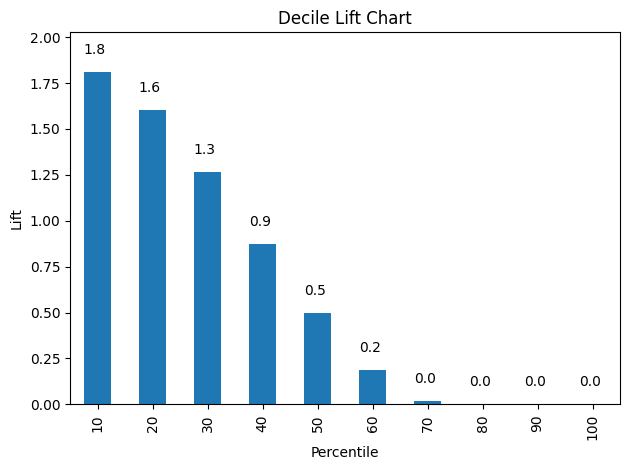

In [221]:
resultPredTrain = pd.DataFrame({'Predicted': df_predicted_probas['Predicted'], 'Actual': y_valid})
liftChart(resultPredTrain.sort_values(by=['Predicted'], ascending=False).Predicted, labelBars=True, title='Decile Lift Chart')
plt.tight_layout()
plt.show()

## 13.2.c The accuracy is  72.12%. The lift on the first decile is 1.8

## 13.2.d RandomForestClassifier Tree

In [222]:
drops = ['ClosePrice']

In [223]:
X_eBay = dfeBay.drop(columns=outcome).drop(columns=drops)
Y_eBay = dfeBay[outcome]
X_train, X_valid, y_train, y_valid = train_test_split(X_eBay, Y_eBay, test_size=0.4, random_state=1)

In [224]:
classTree = RandomForestClassifier(n_estimators=500, random_state=1)
classTree.fit(X_train, y_train)
classificationSummary(y_valid, classTree.predict(X_valid))

Confusion Matrix (Accuracy 0.7364)

       Prediction
Actual   0   1
     0 259  94
     1 114 322


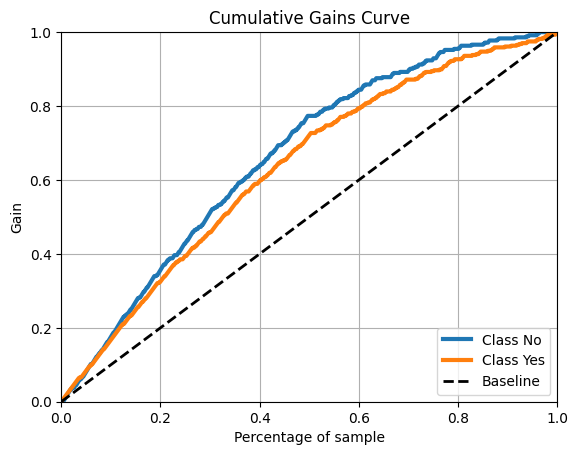

In [225]:
predicted_probas = classTree.predict_proba(X_valid)
skplt.metrics.plot_cumulative_gain(y_valid, predicted_probas)
plt.show()

In [226]:
df_predicted_probas = pd.DataFrame(predicted_probas)
df_predicted_probas['Predicted'] = df_predicted_probas[1]
df_predicted_probas = df_predicted_probas.drop(columns=[0,1])

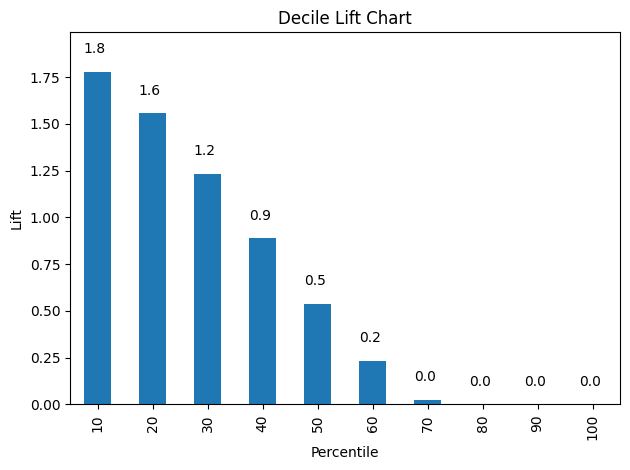

In [227]:
resultPredTrain = pd.DataFrame({'Predicted': df_predicted_probas['Predicted'], 'Actual': y_valid})
liftChart(resultPredTrain.sort_values(by=['Predicted'], ascending=False).Predicted, labelBars=True, title='Decile Lift Chart')
plt.tight_layout()
plt.show()

## 13.2.d The accuracy is  73.64%. The lift on the first decile is 1.8. A random Forest method combines the random variation analysis of multiple cycles to provide an average output, usually providing more accurate predictions.

In [228]:
dfDelays = readFile("https://raw.githubusercontent.com/wolfesamk/MSBA-206/main/dmba/FlightDelays.csv")

In [229]:
dfDelays

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,645,RU,644,EWR,199,1/31/2004,2761,DCA,0,6,31,N15555,ontime
2197,1700,RU,1653,EWR,213,1/31/2004,2497,IAD,0,6,31,N16976,ontime
2198,1600,RU,1558,EWR,199,1/31/2004,2361,DCA,0,6,31,N14902,ontime
2199,1359,RU,1403,EWR,199,1/31/2004,2216,DCA,0,6,31,N16961,ontime


In [230]:
outcome = 'Status'

In [231]:
dfDelays = dfDelays.rename(columns={'Flight Status': outcome})

In [232]:
dfDelays['DAY_WEEK'] = dfDelays['DAY_WEEK'].astype('category')
dfDelays['CRS_DEP_TIME'] = pd.cut(dfDelays['CRS_DEP_TIME'], 8, labels=False)

In [233]:
dfDelays.head(5)

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Status
0,4,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,5,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,3,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,5,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,2,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [234]:
dfDelaysDum = pd.get_dummies(dfDelays.drop(columns=['DAY_OF_MONTH','DEP_TIME']))

In [235]:
dfDelaysDum.head(5)

,CRS_DEP_TIME,DISTANCE,FL_NUM,Weather,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,...,TAIL_NUM_N974DL,TAIL_NUM_N975CA,TAIL_NUM_N983CA,TAIL_NUM_N986DL,TAIL_NUM_N987DL,TAIL_NUM_N994DL,TAIL_NUM_N995CA,TAIL_NUM_N997DL,Status_delayed,Status_ontime
0,4,184,5935,0,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,5,213,6155,0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,3,229,7208,0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,5,229,7215,0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,2,229,7792,0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [236]:
dfDelaysDum = dfDelaysDum.drop(columns=['Status_ontime'])

In [237]:
outcome = 'Status_delayed'

In [238]:
X_Delays = dfDelaysDum.drop(columns=outcome)
Y_Delays = dfDelaysDum[outcome]
X_train, X_valid, y_train, y_valid = train_test_split(X_Delays, Y_Delays, test_size=0.4, random_state=1)

In [239]:
X_Delays = dfDelaysDum.drop(columns=outcome)
Y_Delays = dfDelaysDum[outcome]
X_train, X_valid, y_train, y_valid = train_test_split(X_Delays, Y_Delays, test_size=0.4, random_state=1)

## 13.3.a Regular Tree

In [240]:
classTree = DecisionTreeClassifier(random_state=1)
classTree.fit(X_train, y_train)
classificationSummary(y_valid, classTree.predict(X_valid))

Confusion Matrix (Accuracy 0.7673)

       Prediction
Actual   0   1
     0 613 101
     1 104  63


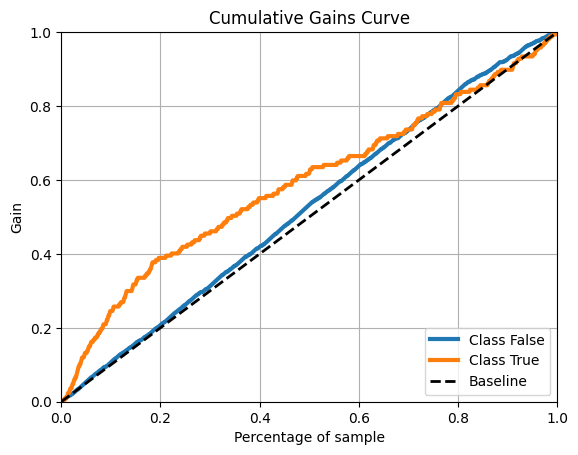

In [241]:
predicted_probas = classTree.predict_proba(X_valid)
skplt.metrics.plot_cumulative_gain(y_valid, predicted_probas)
plt.show()

In [242]:
df_predicted_probas = pd.DataFrame(predicted_probas)
df_predicted_probas['Predicted'] = df_predicted_probas[1]
df_predicted_probas = df_predicted_probas.drop(columns=[0,1])

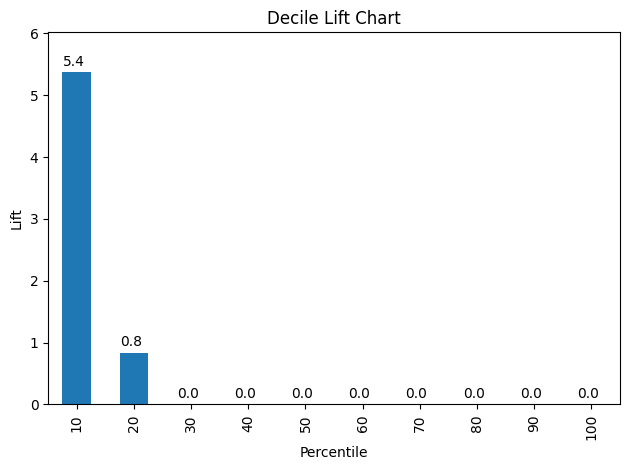

In [243]:
resultPredTrain = pd.DataFrame({'Predicted': df_predicted_probas['Predicted'], 'Actual': y_valid})
liftChart(resultPredTrain.sort_values(by=['Predicted'], ascending=False).Predicted, labelBars=True, title='Decile Lift Chart')
plt.tight_layout()
plt.show()

In [244]:
classificationSummary(Y_Delays, classTree.predict(X_Delays))

Confusion Matrix (Accuracy 0.9069)

       Prediction
Actual    0    1
     0 1672  101
     1  104  324


## 13.3.a The accuracy is 76.73%. The first decile lift is 5.4.

## 13.3.a AdaBoosterClassifier Tree

In [245]:
classTree = AdaBoostClassifier((DecisionTreeClassifier(random_state=1)),n_estimators=500, random_state=1)
classTree.fit(X_train, y_train)
classificationSummary(y_valid, classTree.predict(X_valid))

Confusion Matrix (Accuracy 0.7662)

       Prediction
Actual   0   1
     0 614 100
     1 106  61


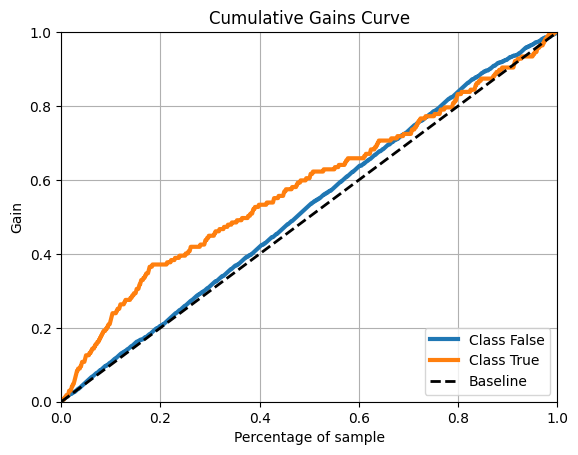

In [246]:
predicted_probas = classTree.predict_proba(X_valid)
skplt.metrics.plot_cumulative_gain(y_valid, predicted_probas)
plt.show()

In [247]:
df_predicted_probas = pd.DataFrame(predicted_probas)
df_predicted_probas['Predicted'] = df_predicted_probas[1]
df_predicted_probas = df_predicted_probas.drop(columns=[0,1])

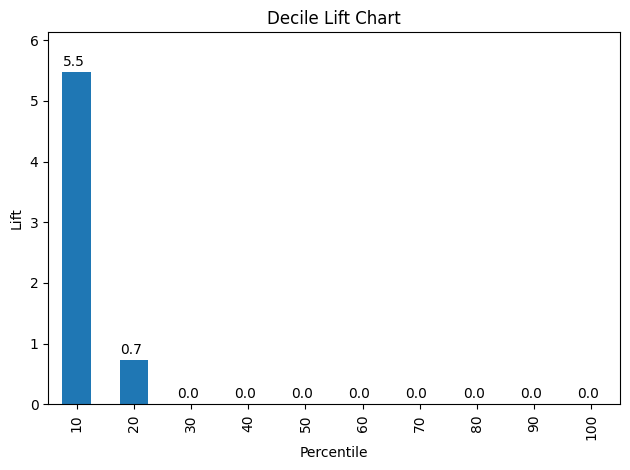

In [248]:
resultPredTrain = pd.DataFrame({'Predicted': df_predicted_probas['Predicted'], 'Actual': y_valid})
liftChart(resultPredTrain.sort_values(by=['Predicted'], ascending=False).Predicted, labelBars=True, title='Decile Lift Chart')
plt.tight_layout()
plt.show()

In [249]:
classificationSummary(Y_Delays, classTree.predict(X_Delays))

Confusion Matrix (Accuracy 0.9064)

       Prediction
Actual    0    1
     0 1673  100
     1  106  322


## 13.3.a The accuracy is 76.62%. The First decile lift is 5.5.

#### 13.3.a Overall boosted has slightly better accuracy.
#### 13.3.b Boosted has slightly worse accuracy, but its lift is better for the first decile.
#### 13.3.c AdaBoost will be more accurate because it systematically cycles through the data until n is reached adjusting the weights of each point until the best model is achieved.